In [1]:
import pandas as pd
import numpy as np
import glob
import os, os.path
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from cartopy import crs as ccrs

In [2]:
from cartopy import crs as ccrs
# cartopy was previously having a weird conflict with shapely
# fixed with an older version "pip install shapely==1.8.5 --user --force-reinstall" 
import matplotlib.colors as colors
from shapely.geometry import Point
from matplotlib.lines import Line2D
import geopandas as gpd
import matplotlib.patches as mpatches

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap,TwoSlopeNorm

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [6]:
cmap1 = cm.get_cmap('PiYG', 128)
cmap2 = truncate_colormap(cmap1, 0.40, 0.60)

(-18491143.68863403, 18491143.68863403, -9473562.580980353, 9191411.568387408)

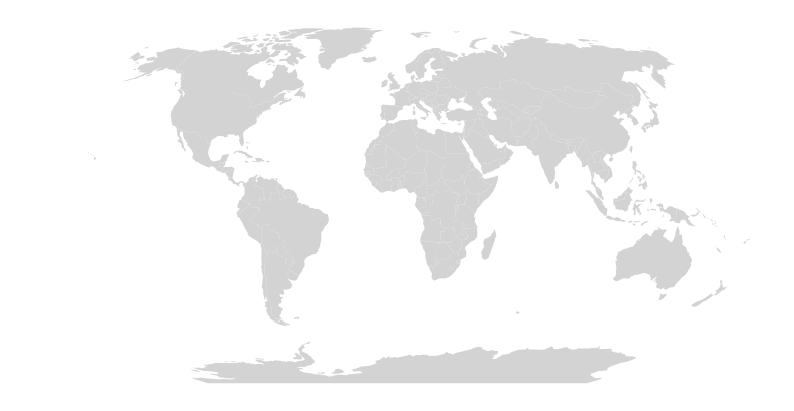

In [7]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
robinson = ccrs.Robinson().proj4_init
fig, ax = plt.subplots(figsize=(10,10))
world.to_crs(robinson).plot(color="lightgrey",ax=ax)
ax.axis('off')

### retirement only 

In [8]:
ret_data = pd.read_csv("../../data/global_GEM/analysis_plant/coal2gas_retired_only.csv")
ret_data_comb = ret_data.groupby(["Coal_Latitude","Coal_Longitude"]).sum()
ret_data_comb = ret_data_comb.reset_index()
ret_data_plot = gpd.GeoDataFrame(ret_data_comb, geometry=gpd.points_from_xy(x=ret_data_comb.Coal_Longitude, y=ret_data_comb.Coal_Latitude),crs='EPSG:4326')
ret_data_plot = ret_data_plot.to_crs(robinson)

In [9]:
op_data = pd.read_csv("../../data/global_GEM/analysis_plant/coal_plant_operating.csv")
op_data_sum = op_data.groupby(["Latitude","Longitude"]).sum()
op_data_sum = op_data_sum.reset_index()
op_data_plot = gpd.GeoDataFrame(op_data_sum, geometry=gpd.points_from_xy(x=op_data_sum.Longitude, y=op_data_sum.Latitude), crs='EPSG:4326')
op_data_plot = op_data_plot.to_crs(robinson) 

In [10]:
# fresh gas plants
fresh_gas = pd.read_csv("../../data/global_GEM/analysis_plant/coal2gas_fresh_gas.csv")
fresh_gas = gpd.GeoDataFrame(fresh_gas, geometry=gpd.points_from_xy(x=fresh_gas.Longitude, y=fresh_gas.Latitude), crs='EPSG:4326')
fresh_gas = fresh_gas.to_crs(robinson) 

### matched plants

In [11]:
gas_plants = pd.read_csv("../../data/global_GEM/analysis_plant/coal2gas_geopandas_match_plants.csv")
gas_manual = pd.read_csv("../../data/global_GEM/analysis_plant/coal2gas_mismatch_plants_manual.csv", engine='python')
gas_plants_comb = pd.concat([gas_plants,gas_manual])
gas_plants_comb = gas_plants_comb[gas_plants_comb["Capacity elec. (MW)"]!="not found"]
gas_plants_comb["Capacity elec. (MW)"] = gas_plants_comb["Capacity elec. (MW)"].astype(float)
gas_plants_plot = gpd.GeoDataFrame(
    gas_plants_comb, geometry=gpd.points_from_xy(x=gas_plants_comb.Longitude, y=gas_plants_comb.Latitude), crs='EPSG:4326')
gas_plants_plot = gas_plants_plot.to_crs(robinson) 

In [12]:
replace_sum = gas_plants_plot[gas_plants_plot["Coal-to-gas conversion/replacement?"]=="replacement"]
replace_sum = replace_sum[["Latitude","Longitude","Capacity elec. (MW)"]].groupby(["Latitude","Longitude"]).sum().reset_index()
replace_sum_plot = gpd.GeoDataFrame(replace_sum, geometry=gpd.points_from_xy(x=replace_sum.Longitude, y=replace_sum.Latitude), crs='EPSG:4326')
replace_sum_plot = replace_sum_plot.to_crs(robinson) 

In [13]:
convert_sum = gas_plants_plot[gas_plants_plot["Coal-to-gas conversion/replacement?"]=="conversion"]
convert_sum = convert_sum[["Latitude","Longitude","Capacity elec. (MW)"]].groupby(["Latitude","Longitude"]).sum().reset_index()
convert_sum_plot = gpd.GeoDataFrame(convert_sum, geometry=gpd.points_from_xy(x=convert_sum.Longitude, y=convert_sum.Latitude), crs='EPSG:4326')
convert_sum_plot = convert_sum_plot.to_crs(robinson) 

In [14]:
other_sum = gas_plants_plot[gas_plants_plot["Coal-to-gas conversion/replacement?"]!="conversion"]
other_sum = other_sum[other_sum["Coal-to-gas conversion/replacement?"]!="replacement"]
other_sum = other_sum[["Latitude","Longitude","Capacity elec. (MW)"]].groupby(["Latitude","Longitude"]).sum().reset_index()
other_sum_plot = gpd.GeoDataFrame(other_sum, geometry=gpd.points_from_xy(x=other_sum.Longitude, y=other_sum.Latitude), crs='EPSG:4326')
other_sum_plot = other_sum_plot.to_crs(robinson) 

### visualization

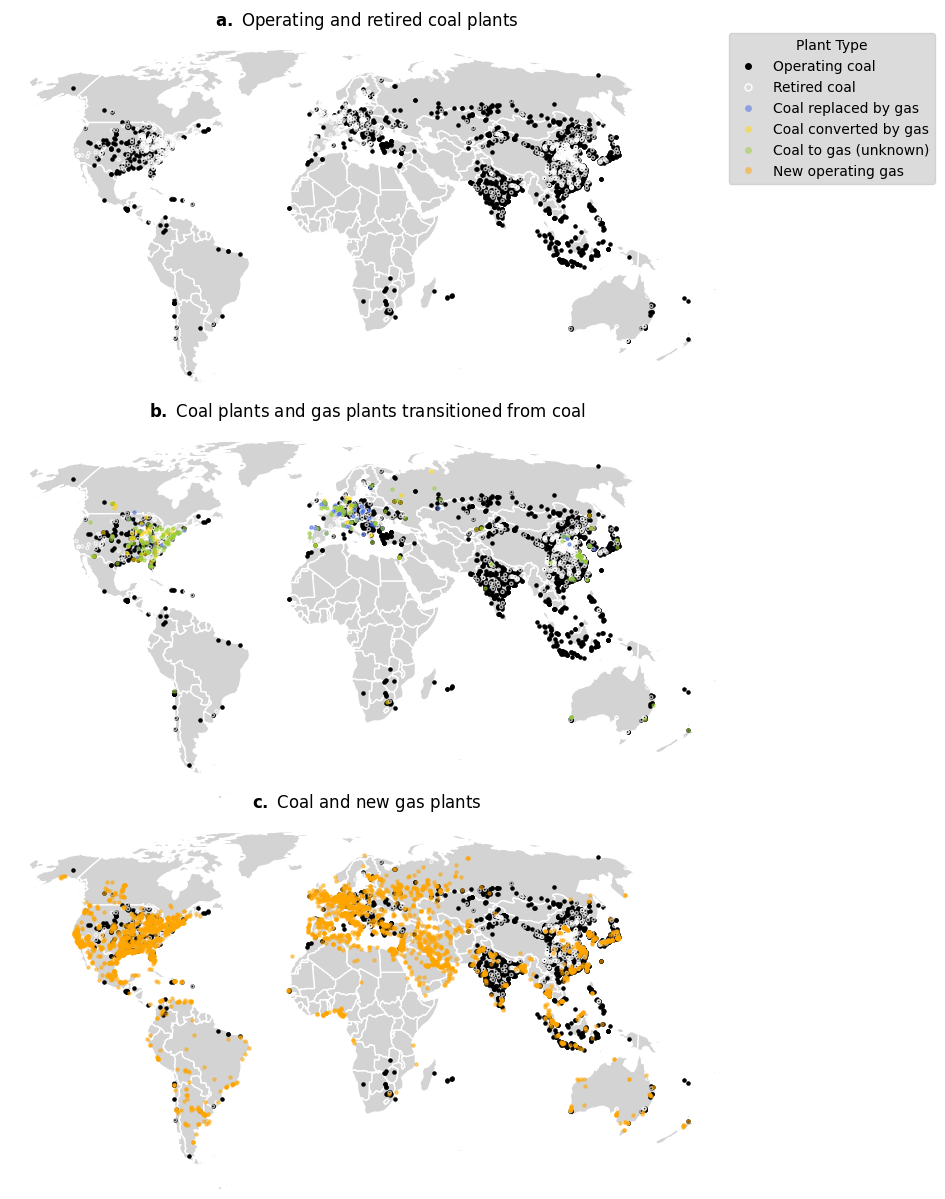

In [15]:
fig, ax = plt.subplots(3,1,figsize=(10,15))
fig.subplots_adjust(wspace=0,hspace=0.05)

for i in np.arange(3):
    ax[i].set_xlim(-13500000,17000000)
    ax[i].set_ylim(-6900000,9000000)
    world.to_crs(robinson).plot(color="lightgrey",edgecolor="white",ax=ax[i])
    ax[i].axis('off')

# first plot
op_data_plot.plot(ax=ax[0],color="black",label="Operating coal",markersize=5)
ret_data_plot.plot(ax=ax[0],edgecolor="white",facecolor="none",label="Retired coal",markersize=5,alpha=0.7)
ax[0].set_title(r"$\bf{a. }$ Operating and retired coal plants")

# second plot
op_data_plot.plot(ax=ax[1],color="black",label="Operating coal",markersize=5)
ret_data_plot.plot(ax=ax[1],edgecolor="white",facecolor="none",label="Retired coal",markersize=5,alpha=0.7)
replace_sum_plot.plot(ax=ax[1],color="royalblue",label="Replacement coal to gas",markersize=5,alpha=0.5)#markersize=replace_sum_plot["Capacity elec. (MW)"]/10)
convert_sum_plot.plot(ax=ax[1],color="gold",label="Conversion coal to gas",markersize=5,alpha=0.5) #markersize=convert_sum_plot["Capacity elec. (MW)"]/10)
other_sum_plot.plot(ax=ax[1],color="yellowgreen",label="Other coal to gas",markersize=5,alpha=0.5)#,markersize=other_sum_plot["Capacity elec. (MW)"]/10
ax[1].set_title(r"$\bf{b. }$ Coal plants and gas plants transitioned from coal")

# third plot
op_data_plot.plot(ax=ax[2],color="black",label="Operating coal",markersize=5)
ret_data_plot.plot(ax=ax[2],edgecolor="white",facecolor="none",label="Retired coal",markersize=5,alpha=0.7)
fresh_gas.plot(ax=ax[2],color="orange",label="Fresh gas",markersize=5,alpha=0.5)
ax[2].set_title(r"$\bf{c. }$ Coal and new gas plants")

legend_elements = [Line2D([0], [0], marker='o', color='none', label='Operating coal',
                          markerfacecolor='black', markeredgecolor="none", markersize=5),
                  Line2D([0], [0], marker='o', color='none', label='Retired coal',
                          markerfacecolor='none',markeredgecolor="white", markersize=5),
                  Line2D([0], [0], marker='o', color='none', label='Coal replaced by gas',
                          markerfacecolor='royalblue',markeredgecolor="none",alpha=0.5,markersize=5),
                  Line2D([0], [0], marker='o', color='none', label='Coal converted by gas',
                          markerfacecolor='gold',markeredgecolor="none", alpha=0.5,markersize=5),
                  Line2D([0], [0], marker='o', color='none', label='Coal to gas (unknown)',
                          markerfacecolor='yellowgreen',markeredgecolor="none",alpha=0.5,markersize=5),
                  Line2D([0], [0], marker='o', color='none', label='New operating gas',
                          markerfacecolor='orange',markeredgecolor="none",alpha=0.5,markersize=5)]
ax[0].legend(handles=legend_elements,
          loc='center', bbox_to_anchor=(1.15,0.8),facecolor="lightgrey",title="Plant Type")
fig.savefig("ExtDataFig3_plants.png",dpi=600, bbox_inches='tight')
#fig.savefig("coal_and_gas_plants.pdf")